In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline

data = pd.read_csv("../data/data_clean.csv")

years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024, 2025]

def get_proj_wins(x_train, x_test, y_train_series):

    model = make_pipeline(StandardScaler(), PoissonRegressor(alpha=0.0001, max_iter=10000)) # Creates poisson regression model as model
    model.fit(x_train, y_train_series) # Fits model to training data
    y_pred = model.predict(x_test)     # Predicts outcome of testing data based on model
    
    scale = 63 / y_pred.sum()         
    
    y_pred_scaled = y_pred * scale    # Scales the output so the sum is 63 (the number of wins in every tournament)
    
    return y_pred_scaled

def get_ranks(data_train, data_test):
    
    x_train = data_train[['Won_ConfT', 'AdjO',
       'AdjD', 'AdjEM', 'BARTHAG', 'EFG%', 'EFG%D', 'FT%', 'FTR', 'FTRD',
       'TOV%', 'TOV%D', 'TOV%_Diff', 'OREB%', 'DREB%', '2PT%', '2PTR', '2PT%D',
       '2PTRD', '3PT%', '3PTR', '3PT%D', '3PTRD', 'AST%', 'Height',
       'Experience', 'Talent', 'AdjT', 'W', 'Elite_SOS', 'WAB', 'FT_Off_Eff',
       'FT_Def_Eff', '2pt_Off_Eff', '2pt_Def_Eff', '3pt_Off_Eff',
       '3pt_Def_Eff', 'AdjO_z', 'AdjD_z', 'BARTHAG_z', 'EFG%_z', 'EFG%D_z',
       'FT_Off_Eff_z', 'FT_Def_Eff_z', 'TOV%_z', 'TOV%D_z', 'OREB%_z',
       'DREB%_z', '2pt_Off_Eff_z', '2pt_Def_Eff_z', '3pt_Off_Eff_z',
       '3pt_Def_Eff_z', 'AST%_z', 'Elite_SOS_z', 'WAB_z']]
    x_test = data_test[['Won_ConfT', 'AdjO',
       'AdjD', 'AdjEM', 'BARTHAG', 'EFG%', 'EFG%D', 'FT%', 'FTR', 'FTRD',
       'TOV%', 'TOV%D', 'TOV%_Diff', 'OREB%', 'DREB%', '2PT%', '2PTR', '2PT%D',
       '2PTRD', '3PT%', '3PTR', '3PT%D', '3PTRD', 'AST%', 'Height',
       'Experience', 'Talent', 'AdjT', 'W', 'Elite_SOS', 'WAB', 'FT_Off_Eff',
       'FT_Def_Eff', '2pt_Off_Eff', '2pt_Def_Eff', '3pt_Off_Eff',
       '3pt_Def_Eff', 'AdjO_z', 'AdjD_z', 'BARTHAG_z', 'EFG%_z', 'EFG%D_z',
       'FT_Off_Eff_z', 'FT_Def_Eff_z', 'TOV%_z', 'TOV%D_z', 'OREB%_z',
       'DREB%_z', '2pt_Off_Eff_z', '2pt_Def_Eff_z', '3pt_Off_Eff_z',
       '3pt_Def_Eff_z', 'AST%_z', 'Elite_SOS_z', 'WAB_z']]
    
    data_test.loc[:, 'Proj_Wins'] = get_proj_wins(x_train, x_test, data_train['Wins'])
    data_test.loc[:, 'Proj_Wins_Rank'] = data_test['Proj_Wins'].rank(ascending=False, method='min').astype(int)
    data_test.loc[:, 'Wins_Rank'] = data_test['Wins'].rank(ascending=False, method='min').astype(int)

    
    return data_test

ranks = []

for year in years:

    data_train = data[data['Year'] < year]
    data_test0 = data[data['Year'] == year].copy()

    data_test = get_ranks(data_train, data_test0)
    
    ranks.append(data_test)
    
df = pd.concat(ranks, axis=0)

df = df[['Year', 'Team', 'Seed', 'Wins', 'Wins_Rank', 'Proj_Wins', 'Proj_Wins_Rank']].sort_values(by='Wins', ascending=False)

teams = pd.read_csv("../data/march_teams.csv")

combined = df.merge(teams, how="outer", on=["Team", "Year"])

combined['Seed'] = combined['Seed_y'].astype(int)
del combined['Seed_y']
del combined['Seed_x']

df = combined.sort_values(by=["Year", "Region"], ascending=False)

df['Sim_Wins'] = [-1 for _ in range(len(df))]

quads = pd.read_csv("../data/quadrants.csv")

def same_seed(df, seed, r):
    
    subdf = pd.DataFrame(df[df["Seed"] == seed])
    team1 = subdf.head(1)
    team1index = team1["Team"].index
    team2 = subdf.tail(1)
    team2index = team2["Team"].index

    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = r

    else:
        df.loc[team1index, "Sim_Wins"] = r
        
    return df

def round64(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    seeds1 = [1,2,3,4,5,6,7,8]
    seeds2 = [16,15,14,13,12,11,10,9]
    
    for i in range(0,8):
        
        rdf = subdf[(subdf["Seed"] == seeds1[i]) | (subdf["Seed"] == seeds2[i])]
        team1 = rdf.head(1)
        team1index = team1["Team"].index
        team2 = rdf.tail(1)
        team2index = team2["Team"].index
        
        if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
            df.loc[team2index, "Sim_Wins"] = 0
            
        else:
            df.loc[team1index, "Sim_Wins"] = 0
            
    return df

def round32(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    team1 = subdf[(subdf["Seed"] == 1) | (subdf["Seed"] == 16)]
    team1index = team1["Team"].index
    team2 = subdf[(subdf["Seed"] == 8) | (subdf["Seed"] == 9)]
    team2index = team2["Team"].index
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 1
    else:
        df.loc[team1index, "Sim_Wins"] = 1
    
    team3 = subdf[(subdf["Seed"] == 5) | (subdf["Seed"] == 12)]
    team3index = team3["Team"].index
    team4 = subdf[(subdf["Seed"] == 4) | (subdf["Seed"] == 13)]
    team4index = team4["Team"].index
    if team3["Proj_Wins"].iloc[0] > team4["Proj_Wins"].iloc[0]:
        df.loc[team4index, "Sim_Wins"] = 1
    else:
        df.loc[team3index, "Sim_Wins"] = 1
    
    team5 = subdf[(subdf["Seed"] == 6) | (subdf["Seed"] == 11)]
    team5index = team5["Team"].index
    team6 = subdf[(subdf["Seed"] == 3) | (subdf["Seed"] == 14)]
    team6index = team6["Team"].index
    if team5["Proj_Wins"].iloc[0] > team6["Proj_Wins"].iloc[0]:
        df.loc[team6index, "Sim_Wins"] = 1
    else:
        df.loc[team5index, "Sim_Wins"] = 1
    
    team7 = subdf[(subdf["Seed"] == 7) | (subdf["Seed"] == 10)]
    team7index = team7["Team"].index
    team8 = subdf[(subdf["Seed"] == 2) | (subdf["Seed"] == 15)]
    team8index = team8["Team"].index
    if team7["Proj_Wins"].iloc[0] > team8["Proj_Wins"].iloc[0]:
        df.loc[team8index, "Sim_Wins"] = 1
    else:
        df.loc[team7index, "Sim_Wins"] = 1
        
    return df

def sweet16(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    options1 = [1,8,9,16]
    for i in options1:
        if not subdf[subdf["Seed"] == i].empty:
            team1 = subdf[subdf["Seed"] == i]
            break
    team1index = team1["Team"].index
    options2 = [4,5,12,13]
    for i in options2:
        if not subdf[subdf["Seed"] == i].empty:
            team2 = subdf[subdf["Seed"] == i]
            break
    team2index = team2["Team"].index
        
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 2
    else:
        df.loc[team1index, "Sim_Wins"] = 2
        
    options3 = [3,6,11,14]
    for i in options3:
        if not subdf[subdf["Seed"] == i].empty:
            team3 = subdf[subdf["Seed"] == i]
            break 
    team3index = team3["Team"].index
    options4 = [2,7,10,15]
    for i in options4:
        if not subdf[subdf["Seed"] == i].empty:
            team4 = subdf[subdf["Seed"] == i]
            break
    team4index = team4["Team"].index
        
    if team3["Proj_Wins"].iloc[0] > team4["Proj_Wins"].iloc[0]:
        df.loc[team4index, "Sim_Wins"] = 2
    else:
        df.loc[team3index, "Sim_Wins"] = 2
        
    return df

def elite8(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    options1 = [1,4,5,8,9,12,13,16]
    for i in options1:
        if not subdf[subdf["Seed"] == i].empty:
            team1 = subdf[subdf["Seed"] == i]
            break
    team1index = team1["Team"].index
    
    options2 = [2,3,6,7,10,11,14,15]
    for i in options2:
        if not subdf[subdf["Seed"] == i].empty:
            team2 = subdf[subdf["Seed"] == i]
            break
    team2index = team2["Team"].index
    
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 3
    else:
        df.loc[team1index, "Sim_Wins"] = 3
        
    return df

def region_simulation(data, year, region):
    
    seeds = list(range(1,17))
    
    df = data[(data["Year"] == year) & (data["Region"] == region)]
    ###########################################################################
    # FIRST FOUR
    r = 0
    
    for seed in seeds:
    
        if df[df["Seed"] == seed].shape[0] != 1:
            
            df = same_seed(df, seed, r)
    ##########################################################################
    ##########################################################################
    # FIRST ROUND (R64)
        
    df = round64(df)
    
    ##########################################################################
    ##########################################################################
    # SECOND ROUND (R32)
    
    df = round32(df)
    
    ##########################################################################
    ##########################################################################
    # SWEET 16
    
    df = sweet16(df)
    
    ##########################################################################
    ##########################################################################
    # ELITE 8
    
    df = elite8(df)
    
    return df

def final4(df, year):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    quads = pd.read_csv("../data/quadrants.csv")
    quads = quads[quads["Year"] == year]
    
    if quads["East"].iloc[0] == 1:
        team1 = subdf[subdf["Region"] == "East"]
    elif quads["West"].iloc[0] == 1:
        team1 = subdf[subdf["Region"] == "West"]
    elif quads["South"].iloc[0] == 1:
        team1 = subdf[subdf["Region"] == "South"]
    elif quads["Midwest"].iloc[0] == 1:
        team1 = subdf[subdf["Region"] == "Midwest"]
    team1index = team1["Team"].index
        
    if quads["East"].iloc[0] == 2:
        team2 = subdf[subdf["Region"] == "East"]
    elif quads["West"].iloc[0] == 2:
        team2 = subdf[subdf["Region"] == "West"]
    elif quads["South"].iloc[0] == 2:
        team2 = subdf[subdf["Region"] == "South"]
    elif quads["Midwest"].iloc[0] == 2:
        team2 = subdf[subdf["Region"] == "Midwest"]
    team2index = team2["Team"].index
        
    if quads["East"].iloc[0] == 3:
        team3 = subdf[subdf["Region"] == "East"]
    elif quads["West"].iloc[0] == 3:
        team3 = subdf[subdf["Region"] == "West"]
    elif quads["South"].iloc[0] == 3:
        team3 = subdf[subdf["Region"] == "South"]
    elif quads["Midwest"].iloc[0] == 3:
        team3 = subdf[subdf["Region"] == "Midwest"]
    team3index = team3["Team"].index
        
    if quads["East"].iloc[0] == 4:
        team4 = subdf[subdf["Region"] == "East"]
    elif quads["West"].iloc[0] == 4:
        team4 = subdf[subdf["Region"] == "West"]
    elif quads["South"].iloc[0] == 4:
        team4 = subdf[subdf["Region"] == "South"]
    elif quads["Midwest"].iloc[0] == 4:
        team4 = subdf[subdf["Region"] == "Midwest"]
    team4index = team4["Team"].index
        
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 4
    else:
        df.loc[team1index, "Sim_Wins"] = 4
     
    if team3["Proj_Wins"].iloc[0] > team4["Proj_Wins"].iloc[0]:
        df.loc[team4index, "Sim_Wins"] = 4
    else:
        df.loc[team3index, "Sim_Wins"] = 4
        
    return df

def championship(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    team1 = subdf.head(1)
    team1index = team1["Team"].index
    team2 = subdf.tail(1)
    team2index = team2["Team"].index
    
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 5
        df.loc[team1index, "Sim_Wins"] = 6
    else:
        df.loc[team1index, "Sim_Wins"] = 5
        df.loc[team2index, "Sim_Wins"] = 6
        
    return df

def bracket_simulation(data, year):
    
    df1 = region_simulation(data, year, "West")
    df2 = region_simulation(data, year, "East")
    df3 = region_simulation(data, year, "South")
    df4 = region_simulation(data, year, "Midwest")
    
    df = pd.concat([df1, df2, df3, df4])
    
    df = final4(df, year)
    
    df = championship(df)
                            
    return df

dfs = []

for year in years:
    
    dfs.append(bracket_simulation(df, year))
    
sim_df = pd.concat(dfs)
sim_df = sim_df[["Year", "Team", "Seed", "Region", "Proj_Wins", "Wins", "Sim_Wins"]]
df = sim_df.sort_values(["Year", "Wins", "Sim_Wins"], ascending=False)

def bracket_check(df, years):  
    
    scores = []

    for year in years:

        score = 0

        score = score + (10 * (len(df[(df["Year"] == year) & (df["Wins"] > 0) & (df["Sim_Wins"] > 0)])))
        score = score + (20 * (len(df[(df["Year"] == year) & (df["Wins"] > 1) & (df["Sim_Wins"] > 1)])))
        score = score + (40 * (len(df[(df["Year"] == year) & (df["Wins"] > 2) & (df["Sim_Wins"] > 2)])))
        score = score + (80 * (len(df[(df["Year"] == year) & (df["Wins"] > 3) & (df["Sim_Wins"] > 3)])))
        score = score + (160 * (len(df[(df["Year"] == year) & (df["Wins"] > 4) & (df["Sim_Wins"] > 4)])))
        score = score + (320 * (len(df[(df["Year"] == year) & (df["Wins"] > 5) & (df["Sim_Wins"] > 5)])))

        scores.append(score)

    x = np.arange(len(years))

    plt.figure(figsize=(12, 5))

    plt.bar(x, scores, color='g', label='Score')

    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.xticks(x, years)
    for i, score in enumerate(scores):
               plt.text(i, score, str(score), ha='center', va='bottom') 

    plt.show()
    
    df["Diff"] = abs(df["Wins"] - df["Sim_Wins"])
    
    avg = sum(scores) / len(scores)
    avgdiff = sum(df["Diff"]) / len(df["Diff"])

    print("Average:", round(avg, 3))
    print("Avg. Differential:", round(avgdiff, 3))



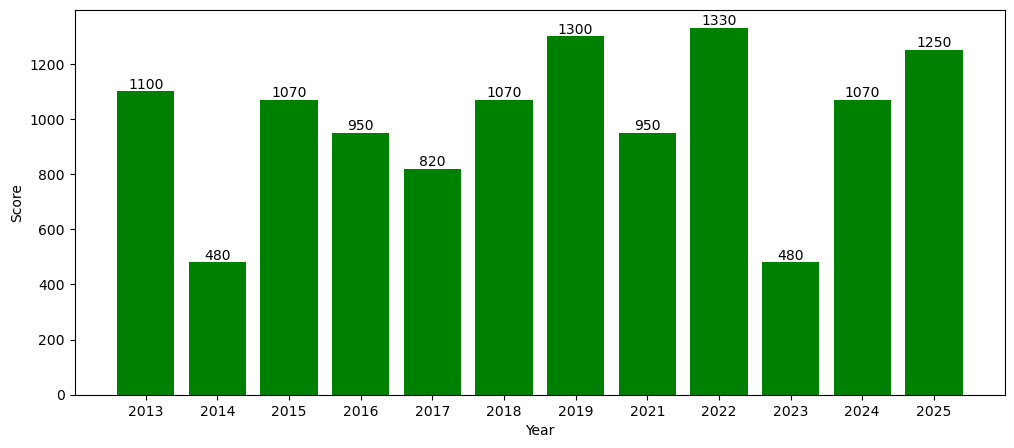

Average: 989.167
Avg. Differential: 0.659


In [29]:
bracket_check(df, years)

In [30]:
df[(df["Seed"] > 9) & (df["Sim_Wins"] > 0)]

,Year,Team,Seed,Region,Proj_Wins,Wins,Sim_Wins,Diff
330,2024,Colorado,10,South,1.116761,1,1,0
439,2024,New Mexico,11,West,1.155271,0,1,1
512,2024,Drake,10,East,0.914897,0,1,1
493,2023,Boise St.,10,West,0.765688,0,1,1
524,2023,Utah St.,10,South,0.600356,0,1,1
57,2022,Miami FL,10,Midwest,0.935752,3,1,2
146,2022,Michigan,11,South,0.789808,2,1,1
206,2022,Notre Dame,11,West,0.850464,1,1,0
194,2019,Florida,10,West,1.307483,1,1,0
254,2018,Butler,10,East,1.344395,1,1,0


In [43]:
df[(df["Year"] == 2015)].head(60).sort_values(["Sim_Wins", "Wins", "Proj_Wins"], ascending=False)

,Year,Team,Seed,Region,Proj_Wins,Wins,Sim_Wins,Diff
15,2015,Wisconsin,1,West,6.767779,5,6,1
359,2015,Virginia,2,East,4.102590,1,5,4
6,2015,Duke,1,South,2.065962,6,4,2
29,2015,Kentucky,1,Midwest,4.560896,4,4,0
74,2015,Arizona,2,West,2.991175,3,3,0
69,2015,Gonzaga,2,South,1.727372,3,3,0
371,2015,Villanova,1,East,2.690201,1,3,2
367,2015,Kansas,2,Midwest,1.478029,1,3,2
64,2015,Louisville,4,East,1.593942,3,2,1
96,2015,North Carolina,4,West,2.358822,2,2,0


In [42]:
df[(df["Year"] == 2018) & (df["Seed"] == 10)]

,Year,Team,Seed,Region,Proj_Wins,Wins,Sim_Wins,Diff
254,2018,Butler,10,East,1.344395,1,1,0
783,2018,Providence,10,West,0.664388,0,0,0
797,2018,Texas,10,South,0.876500,0,0,0
788,2018,Oklahoma,10,Midwest,0.829521,0,0,0
